# **WEEK 10 MACHINE LEARNING**
## PRAKTIKUM 10
NAMA: MAIDY PUTRI JOSHI

NIM: 2141720060

KELAS: TI-3F

**DAFTAR ISI:**

1. PRAKTIKUM 1
2. PRAKTIKUM 2
3. TUGAS PRAKTIKUM

In [ ]:
# Import library NumPy sebagai np
import numpy as np

# Import TensorFlow Datasets sebagai tfds
import tensorflow_datasets as tfds

# Import TensorFlow sebagai tf
import tensorflow as tf

# Menonaktifkan progress bar dari TensorFlow Datasets
tfds.disable_progress_bar()

In [ ]:
# Import library Matplotlib sebagai plt
import matplotlib.pyplot as plt

# Fungsi untuk membuat plot grafik dari histori pelatihan
def plot_graphs(history, metric):

  plt.plot(history.history[metric]) # Menyusun plot dari nilai metric pada setiap epoch pada data pelatihan
  plt.plot(history.history['val_'+metric], '') # Menyusun plot dari nilai metric pada setiap epoch pada data validasi, menggunakan garis putus-putus ('')
  plt.xlabel("Epochs") # Menambahkan label sumbu x dengan teks "Epochs"
  plt.ylabel(metric) # Menambahkan label sumbu y dengan teks metric yang diberikan
  plt.legend([metric, 'val_'+metric]) # Menambahkan legenda ke plot, menunjukkan label metric dan 'val_metric'

In [ ]:
# Menggunakan TensorFlow Datasets untuk memuat dataset 'imdb_reviews' dengan informasi dataset
# as_supervised=True digunakan agar data dapat dimuat sebagai pasangan (data, label)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Memisahkan dataset menjadi bagian pelatihan dan uji
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan informasi tentang struktur elemen pada bagian pelatihan dataset
train_dataset.element_spec


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Mengambil satu contoh (pasangan data dan label) dari bagian pelatihan dataset
for example, label in train_dataset.take(1):
  # Mencetak nilai data (text) dari contoh menggunakan metode .numpy()
  print('text: ', example.numpy())
  # Mencetak nilai label dari contoh menggunakan metode .numpy()
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
# Mengatur ukuran buffer untuk pengacakan dataset
BUFFER_SIZE = 10000

# Mengatur ukuran batch yang akan digunakan pada pelatihan dan pengujian
BATCH_SIZE = 64

# Pengacakan, pembagian batch, dan prefetching untuk bagian pelatihan dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Pembagian batch dan prefetching untuk bagian uji dataset
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengambil satu batch (pasangan data dan label) dari bagian pelatihan dataset
for example, label in train_dataset.take(1):
  # Mencetak tiga nilai data (texts) dari contoh menggunakan metode .numpy() untuk beberapa contoh
  print('texts: ', example.numpy()[:3])
  print()
  # Mencetak tiga nilai label dari contoh menggunakan metode .numpy() untuk beberapa contoh
  print('labels: ', label.numpy()[:3])


texts:  [b'Keanu Reeves stars as a friend of a popular high school student who suddenly commits suicide...he and his friends go through emotional turmoil and share their reactions to this horrible incident...Good acting by Reeves and a young Jennifer Rubin..but on the whole is a little too much.. 4 of 10'
 b"Rodney Dangerfield isn't the main character of this movie. He's barely in it. Most of the screen time is dominated by unfunny jokes. One running gag is that a character is named Jerk Off. There are also lots of erection jokes, where the punch line is someone has an erection. This movie is as funny as Kirstie Ally's British accent is convincing.<br /><br />This movie started off like a weak action movie: five minutes of back story and then bam! Unfunny jokes. But, aside from the terrible writing, the movie is also poorly directed and the acting is terrible. Also, this movie does the old bad comedy clich\xc3\xa9 of having lots of well-known B-movie actors. Harland Williams, Gilbert G

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
# Menentukan ukuran vokabular yang akan digunakan
VOCAB_SIZE = 1000

# Membuat layer TextVectorization dengan konfigurasi jumlah maksimum token (vokabular)
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Mengadaptasi layer TextVectorization ke dataset pelatihan
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
# Mendapatkan vokabular dari layer TextVectorization
vocab = np.array(encoder.get_vocabulary())

# Mencetak 20 token pertama dari vokabular
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
# Menggunakan layer TextVectorization (encoder) untuk mengkodekan contoh teks
encoded_example = encoder(example)[:3].numpy()

# Mencetak hasil encoding untuk tiga contoh pertama
encoded_example

array([[  1,   1, 390, ...,   0,   0,   0],
       [  1,   1, 207, ...,   0,   0,   0],
       [ 10,  26,  75, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
# Melakukan loop untuk tiga contoh
for n in range(3):
  # Mencetak teks asli dari contoh
  print("Original: ", example[n].numpy())
  # Mencetak teks yang telah di-"round-trip" (dikodekan dan didekodekan kembali)
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  # Mencetak baris kosong untuk pemisah antar contoh
  print()

Original:  b'Keanu Reeves stars as a friend of a popular high school student who suddenly commits suicide...he and his friends go through emotional turmoil and share their reactions to this horrible incident...Good acting by Reeves and a young Jennifer Rubin..but on the whole is a little too much.. 4 of 10'
Round-trip:  [UNK] [UNK] stars as a friend of a [UNK] high school [UNK] who [UNK] [UNK] [UNK] and his friends go through emotional [UNK] and [UNK] their [UNK] to this horrible [UNK] acting by [UNK] and a young [UNK] [UNK] on the whole is a little too much 4 of 10                                                                                                                                                                                                                                                                                                                                                                                                                                            

diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
- Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
- Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi

Kode nya adalah sebagai berikut :

In [ ]:
# Membuat model sequential dengan layer-layer berikut:
model = tf.keras.Sequential([
    # Layer TextVectorization (encoder) untuk mengubah teks menjadi representasi numerik
    encoder,
    # Layer Embedding untuk mapping representasi numerik ke vektor berdimensi 64
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Menggunakan masking untuk menangani panjang urutan yang bervariasi
        mask_zero=True),
    # Layer Bidirectional LSTM dengan 64 unit untuk memahami konteks sepanjang urutan
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # Layer Dense dengan 64 unit dan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),
    # Layer Dense dengan 1 unit untuk output binary (binary classification)
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.01421347]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 372ms/step
[-0.01421347]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 889s 2s/step - loss: 0.6328 - accuracy: 0.5719 - val_loss: 0.4731 - val_accuracy: 0.7615
Epoch 2/10
391/391 [==============================] - 865s 2s/step - loss: 0.4306 - accuracy: 0.7914 - val_loss: 0.3939 - val_accuracy: 0.8281
Epoch 3/10
391/391 [==============================] - 890s 2s/step - loss: 0.3598 - accuracy: 0.8401 - val_loss: 0.3525 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 720s 2s/step - loss: 0.3282 - accuracy: 0.8592 - val_loss: 0.3457 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 672s 2s/step - loss: 0.3165 - accuracy: 0.8632 - val_loss: 0.3286 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 676s 2s/step - loss: 0.3082 - accuracy: 0.8696 - val_loss: 0.3281 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 692s 2s/step - loss: 0.3060 - accuracy: 0.8692 - val_loss: 0.3246 - val_accuracy: 0.8542

In [ ]:
# Evaluasi model pada dataset uji dan mendapatkan nilai loss dan akurasi
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak nilai loss pada dataset uji
print('Test Loss:', test_loss)

# Mencetak nilai akurasi pada dataset uji
print('Test Accuracy:', test_acc)

391/391 [==============================] - 205s 525ms/step - loss: 0.3178 - accuracy: 0.8648
Test Loss: 0.3177594840526581
Test Accuracy: 0.864799976348877


(0.0, 0.6496644005179405)

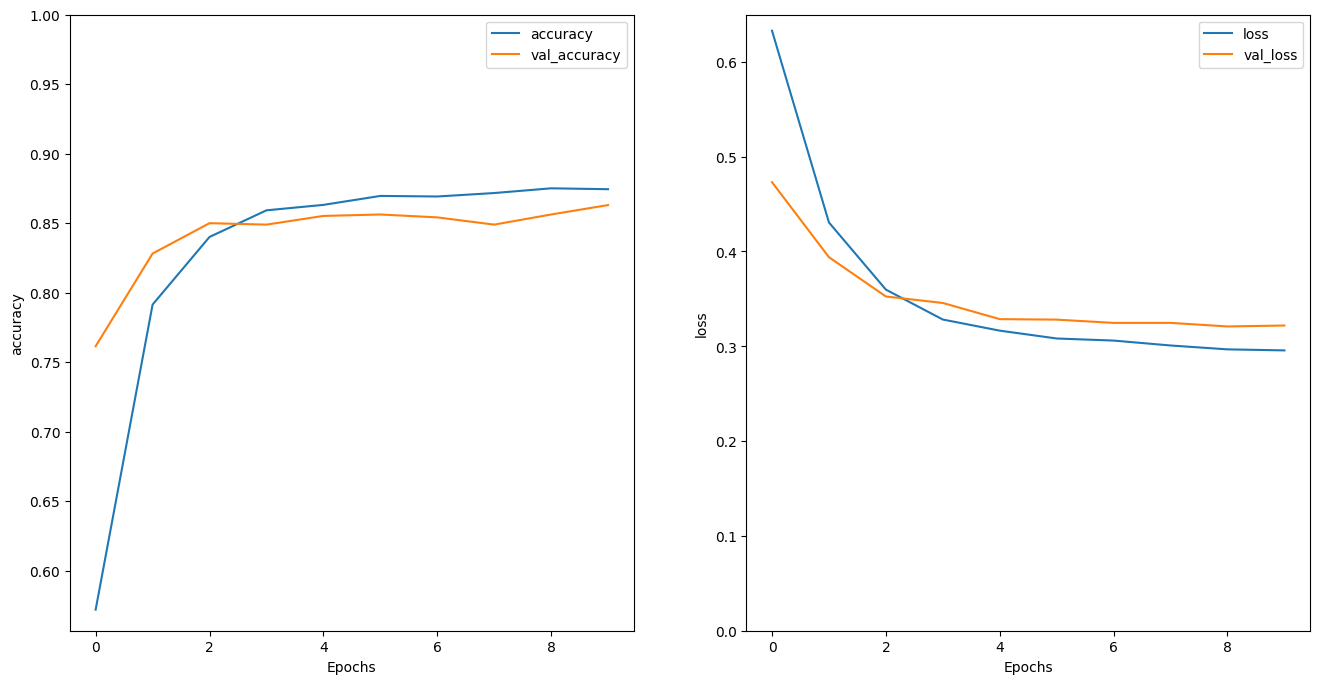

In [ ]:
# Membuat gambar berukuran 16x8 inci
plt.figure(figsize=(16, 8))

# Membuat subplot pertama (1 baris, 2 kolom, subplot pertama)
plt.subplot(1, 2, 1)
# Memanggil fungsi plot_graphs untuk plot akurasi dari histori pelatihan
plot_graphs(history, 'accuracy')
# Mengatur batas y dari subplot pertama menjadi (None, 1)
plt.ylim(None, 1)

# Membuat subplot kedua (1 baris, 2 kolom, subplot kedua)
plt.subplot(1, 2, 2)
# Memanggil fungsi plot_graphs untuk plot loss dari histori pelatihan
plot_graphs(history, 'loss')
# Mengatur batas y dari subplot kedua menjadi (0, None)
plt.ylim(0, None)


Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
# Menentukan teks sampel untuk melakukan prediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi menggunakan model pada teks sampel yang diberikan
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
# Membuat model sequential dengan layer-layer berikut:
model = tf.keras.Sequential([
    # Layer TextVectorization (encoder) untuk mengubah teks menjadi representasi numerik
    encoder,
    # Layer Embedding untuk mapping representasi numerik ke vektor berdimensi 64 dengan masking
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    # Layer Bidirectional LSTM dengan 64 unit untuk memahami konteks sepanjang urutan
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # Layer Bidirectional LSTM dengan 32 unit
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # Layer Dense dengan 64 unit dan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),
    # Layer Dropout untuk mengurangi overfitting
    tf.keras.layers.Dropout(0.5),
    # Layer Dense dengan 1 unit untuk output binary (binary classification)
    tf.keras.layers.Dense(1)
])

In [ ]:
# Mengompilasi model dengan menggunakan Binary Crossentropy sebagai fungsi loss
# from_logits=True digunakan karena model memberikan output logits tanpa aktivasi sigmoid
# Optimizer yang digunakan adalah Adam dengan learning rate 1e-4
# Metrik yang diukur adalah akurasi
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [ ]:
# Melatih model menggunakan dataset pelatihan dengan 10 epochs
# validation_data adalah dataset uji yang digunakan untuk validasi selama pelatihan
# validation_steps menentukan jumlah langkah validasi yang diambil pada setiap epoch
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 1483s 4s/step - loss: 0.2913 - accuracy: 0.8769 - val_loss: 0.3205 - val_accuracy: 0.8646
Epoch 2/10
391/391 [==============================] - 1460s 4s/step - loss: 0.2896 - accuracy: 0.8773 - val_loss: 0.3284 - val_accuracy: 0.8474
Epoch 3/10
391/391 [==============================] - 1453s 4s/step - loss: 0.2873 - accuracy: 0.8772 - val_loss: 0.3351 - val_accuracy: 0.8354
Epoch 4/10
391/391 [==============================] - 1453s 4s/step - loss: 0.2846 - accuracy: 0.8775 - val_loss: 0.3277 - val_accuracy: 0.8401
Epoch 5/10
391/391 [==============================] - 1483s 4s/step - loss: 0.2830 - accuracy: 0.8791 - val_loss: 0.3485 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 1484s 4s/step - loss: 0.2815 - accuracy: 0.8794 - val_loss: 0.3332 - val_accuracy: 0.8516
Epoch 7/10
391/391 [==============================] - 1538s 4s/step - loss: 0.2805 - accuracy: 0.8801 - val_loss: 0.3309 - val_accuracy:

In [ ]:
# Evaluasi model pada dataset uji dan mendapatkan nilai loss dan akurasi
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak nilai loss pada dataset uji
print('Test Loss:', test_loss)

# Mencetak nilai akurasi pada dataset uji
print('Test Accuracy:', test_acc)

391/391 [==============================] - 375s 958ms/step - loss: 0.3338 - accuracy: 0.8587
Test Loss: 0.3337913751602173
Test Accuracy: 0.858680009841919


In [ ]:
# Melakukan prediksi pada sebuah teks sampel tanpa padding
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Melakukan prediksi menggunakan model pada teks sampel yang diberikan
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions)

1/1 [==============================] - 12s 12s/step
[[-1.8343757]]


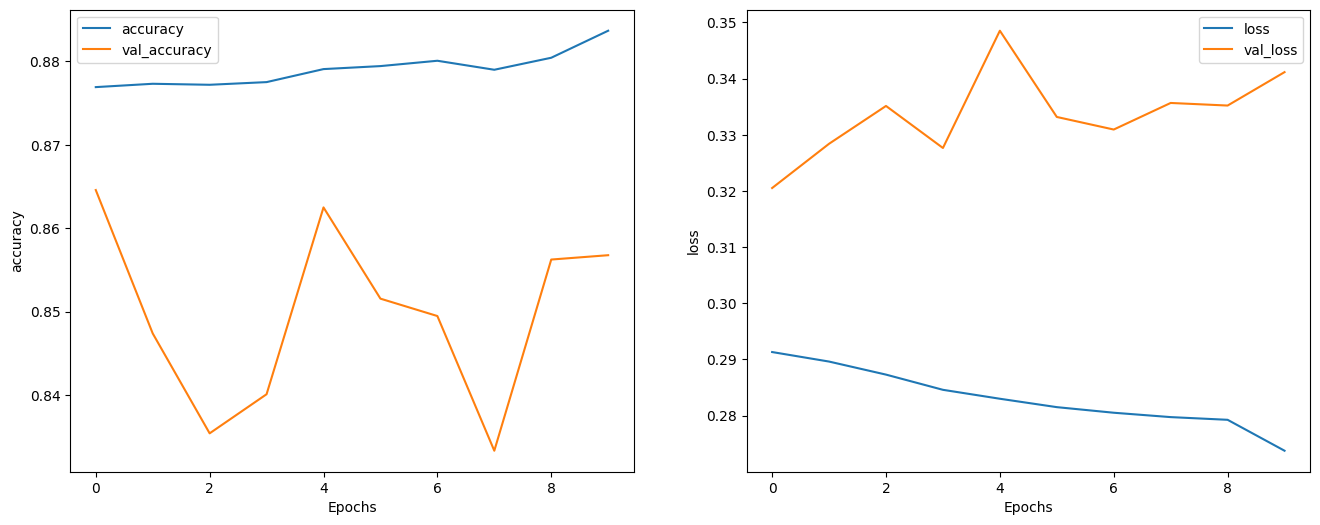

In [ ]:
# Membuat gambar berukuran 16x6 inci dengan dua subplot
plt.figure(figsize=(16, 6))

# Membuat subplot pertama (1 baris, 2 kolom, subplot pertama)
plt.subplot(1, 2, 1)
# Memanggil fungsi plot_graphs untuk plot akurasi dari histori pelatihan
plot_graphs(history, 'accuracy')

# Membuat subplot kedua (1 baris, 2 kolom, subplot kedua)
plt.subplot(1, 2, 2)
# Memanggil fungsi plot_graphs untuk plot loss dari histori pelatihan
plot_graphs(history, 'loss')

# **PRAKTIKUM 2 - Generator Teks dengan RNN**

Praktikum ini mendemonstrasikan cara melakukan genearsi text menggunakan RNN. Dataset yang digunkan adalah dataset Shakespeare's writing from Andrej Karpathy's The Unreasonable Effectiveness of Recurrent Neural Networks. Jika diberikan urutan karakter dari data ini ("Shakespear"), latih model untuk memprediksi karakter berikutnya dalam urutan ("e"). Urutan teks yang lebih panjang dapat dihasilkan dengan memanggil model berulang kali.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: Runtime > Change runtime type > Hardware accelerator > GPU.

Tutorial ini menggunakan tf.keras dan eager execution. Berikut adalah contoh output ketika model dalam tutorial ini dilatih selama 30 epoch, dan dimulai dengan prompt "Q":

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

Sesuaikan dengan lokasi data yang Anda punya.

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapiS.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

Vectorize Teks
Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [ ]:
# Menentukan teks contoh sebagai list
example_texts = ['abcdefg', 'xyz']

# Membagi setiap karakter dalam teks contoh menggunakan unicode_split
# dengan input_encoding='UTF-8'
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')

# Mencetak hasil pembagian karakter
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [ ]:
# Membuat layer StringLookup untuk mengubah karakter menjadi ID
# dengan menggunakan vokabular yang diperoleh sebelumnya
# mask_token=None digunakan karena tidak ada token khusus untuk masking
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab),
    mask_token=None
)

perintah diatas mengconvert token menjadi id

In [ ]:
# Menggunakan layer StringLookup (ids_from_chars) untuk mengubah setiap karakter dalam chars menjadi ID
ids = ids_from_chars(chars)

# Mencetak hasil ID dari setiap karakter
ids


<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode tf.keras.layers.StringLookup(..., invert=True).

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama.

In [ ]:
# Membuat layer StringLookup untuk mengonversi karakter ke ID dan sebaliknya.
chars_from_ids = tf.keras.layers.StringLookup(
    # Menggunakan vocabulary yang diambil dari ids_from_chars untuk mapping karakter ke ID.
    vocabulary=ids_from_chars.get_vocabulary(),
    # Invert=True mengizinkan konversi ID ke karakter.
    invert=True,
    # Mengatur mask_token ke None karena tidak ada mask token yang digunakan.
    mask_token=None
)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [ ]:
# Menggunakan layer StringLookup (chars_from_ids) untuk mengonversi ID ke karakter.
chars = chars_from_ids(ids)

# Melakukan pengonversian ID ke karakter menggunakan layer StringLookup.
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [ ]:
# Menggunakan tf.strings.reduce_join untuk menggabungkan karakter ke dalam satu string.
# Axis=-1 berarti penggabungan dilakukan sepanjang dimensi terakhir (axis terakhir).
# Mengonversi hasil tensor ke dalam bentuk numpy array.
resulting_string = tf.strings.reduce_join(chars, axis=-1).numpy()

In [ ]:
# Membuat fungsi text_from_ids untuk mengonversi rangkaian ID menjadi teks.
def text_from_ids(ids):
    # Menggunakan chars_from_ids untuk mengonversi ID ke karakter.
    chars = chars_from_ids(ids)
    # Menggunakan tf.strings.reduce_join untuk menggabungkan karakter menjadi satu string.
    # Axis=-1 berarti penggabungan dilakukan sepanjang dimensi terakhir (axis terakhir).
    return tf.strings.reduce_join(chars, axis=-1)

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?

Membuat Trianing Set dan Target

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [ ]:
# Menggunakan ids_from_chars untuk mengonversi teks menjadi serangkaian ID.
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

# Melakukan konversi teks ke serangkaian ID menggunakan metode unicode_split pada encoding UTF-8.
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
# Membuat dataset TensorFlow dari tensor serangkaian ID menggunakan from_tensor_slices.
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

# Setiap elemen dalam dataset akan menjadi satu ID dari serangkaian ID.

In [ ]:
# Mengambil 10 elemen pertama dari ids_dataset dan mencetak hasil konversi ke teks.
for ids in ids_dataset.take(10):
    # Menggunakan chars_from_ids untuk mengonversi ID ke karakter, lalu dikonversi menjadi numpy array.
    # Hasilnya kemudian didecode menggunakan UTF-8 untuk mencetak teks.
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
# Menentukan panjang sekuens (sequence length) menjadi 100.
seq_length = 100

# Panjang sekuens digunakan untuk menentukan panjang setiap potongan data dalam dataset.

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [ ]:
# Membagi dataset serangkaian ID menjadi potongan-potongan sekuens dengan panjang seq_length+1.
# drop_remainder=True memastikan bahwa setiap potongan memiliki panjang yang sama.
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

# Mengambil satu potongan sekuens dari dataset dan mencetak hasil konversi ID ke karakter.
for seq in sequences.take(1):
  # Menggunakan chars_from_ids untuk mengonversi ID ke karakter.
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [ ]:
# Mengambil lima potongan sekuens dari dataset dan mencetak hasil konversi ID ke teks.
for seq in sequences.take(5):
    # Menggunakan fungsi text_from_ids untuk mengonversi ID ke teks, lalu diconvert ke dalam bentuk numpy array.
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [ ]:
# Mendefinisikan fungsi split_input_target untuk membagi setiap sekuens menjadi input dan target.
def split_input_target(sequence):
    # input_text adalah sekuens kecuali elemen terakhir.
    input_text = sequence[:-1]
    # target_text adalah sekuens kecuali elemen pertama.
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
# Menggunakan fungsi split_input_target untuk membagi sekuens karakter "Tensorflow" menjadi input dan target.
split_input_target(list("Tensorflow"))
# Output: (['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'], ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
# Menerapkan fungsi split_input_target pada setiap elemen dalam dataset sequences.
dataset = sequences.map(split_input_target)

# Hasilnya adalah dataset baru yang berisi pasangan input dan target untuk setiap sekuens.

In [ ]:
# Mengambil satu contoh input dan target dari dataset, lalu mencetak hasil konversi ID ke teks.
for input_example, target_example in dataset.take(1):
    # Mencetak teks dari input_example.
    print("Input :", text_from_ids(input_example).numpy())
    # Mencetak teks dari target_example.
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Membuat Batch Training

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

Buat Model

Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat Making new Layers and Models via subclassing).

Model yang kita bangun memiliki 3 lapisan neural network :
- tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;
- tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)
- tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [ ]:
# Jumlah kata dalam vokabuler yang digunakan oleh layer StringLookup.
vocab_size = len(ids_from_chars.get_vocabulary())

# Dimensi embedding yang digunakan dalam model.
embedding_dim = 256

# Jumlah unit dalam layer RNN (Recurrent Neural Network).
rnn_units = 1024

In [ ]:
# Mendefinisikan kelas MyModel sebagai subkelas dari tf.keras.Model.
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)

        # Layer embedding untuk mengonversi ID ke dalam vektor embedding.
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Layer GRU (Gated Recurrent Unit) sebagai tipe layer RNN.
        self.gru = tf.keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            return_state=True
        )

        # Layer Dense untuk memprediksi vokabuler berikutnya.
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)

        # Jika states tidak diberikan, dapatkan initial state dari layer GRU.
        if states is None:
            states = self.gru.get_initial_state(x)

        # Melakukan operasi GRU pada input dengan initial state yang sesuai.
        x, states = self.gru(x, initial_state=states, training=training)

        # Melakukan prediksi menggunakan layer Dense.
        x = self.dense(x, training=training)

        # Mengembalikan output dan (opsional) state terakhir.
        if return_state:
            return x, states
        else:
            return x

In [ ]:
# Membuat instance dari kelas MyModel dengan parameter yang telah ditentukan sebelumnya.
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

Untuk setiap karakter, model mencari penyematan, menjalankan GRU satu langkah waktu dengan penyematan sebagai masukan, dan menerapkan dense layer untuk menghasilkan log yang memprediksi kemungkinan log karakter berikutnya:

Note: Untuk pelatihan Anda bisa menggunakan model keras.Sequential di sini. Untuk menghasilkan teks nanti, Anda harus mengelola status internal RNN. Akan lebih mudah untuk memasukkan opsi input dan output status di awal, daripada mengatur ulang arsitektur model nanti. untuk detailnya bisa dilihat Keras RNN guide.

**Uji Model**

Coba jalankan model dan cek apakah sidah sesuai dengan output pertama, cek bentuk dari output

In [ ]:
# Mengambil satu batch contoh input dan target dari dataset.
for input_example_batch, target_example_batch in dataset.take(1):
    # Melakukan prediksi menggunakan model pada batch contoh input.
    example_batch_predictions = model(input_example_batch)

    # Mencetak dimensi hasil prediksi.
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter. Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch:

In [ ]:
# Menggunakan distribusi kategori acak (random.categorical) untuk mengambil sampel indeks dari prediksi.
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)

# Menghilangkan dimensi yang tidak perlu menggunakan squeeze dan mengonversi hasil ke dalam numpy array.
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [ ]:
sampled_indices

array([56, 46,  8, 60, 16, 30, 47, 32, 46, 28, 11, 18, 59, 24, 30, 10, 16,
       36, 36, 26, 18, 37, 39, 32, 23, 61, 62, 30, 56, 57, 10, 12, 14, 64,
       13, 51, 32,  2, 40, 48, 31, 38,  2, 19, 26, 45, 29, 54, 49, 22,  0,
       47, 56, 59, 43,  9,  0, 41, 25, 44, 36,  3, 38, 65,  9, 51, 13, 19,
       40, 12,  7, 51, 30, 43, 39, 53, 27, 20,  2, 30, 21, 56, 65, 38, 16,
       16, 24, 56, 48, 36,  8,  1, 13, 10,  4, 60, 16,  3, 17, 38])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [ ]:
# Mencetak teks dari contoh input dalam batch.
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()

# Mencetak teks dari prediksi karakter berikutnya.
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'?\n\nAUFIDIUS:\nAll places yield to him ere he sits down;\nAnd the nobility of Rome are his:\nThe senator'

Next Char Predictions:
 b'qg-uCQhSgO:EtKQ3CWWMEXZSJvwQqr3;Ay?lS aiRY FMfPojI[UNK]hqtd.[UNK]bLeW!Yz.l?Fa;,lQdZnNG QHqzYCCKqiW-\n?3$uC!DY'


**Train Model**

Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

Tambahan optimizer dan fungsi loss

loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [ ]:
# Menggunakan fungsi SparseCategoricalCrossentropy sebagai fungsi loss.
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Menghitung nilai loss pada contoh batch menggunakan SparseCategoricalCrossentropy.
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)

# Mencetak dimensi hasil prediksi dan nilai rata-rata loss pada contoh batch.
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1903367, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.04502

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [ ]:
model.compile(optimizer='adam', loss=loss)

Konfigurasi Checkpoints

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [ ]:
# Menentukan direktori tempat checkpoint akan disimpan.
checkpoint_dir = './training_checkpoints'

# Menentukan nama file checkpoint dengan format "ckpt_epoch".
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Membuat callback untuk menyimpan checkpoint model.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

Lakukan Proses Training

Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.

In [ ]:
EPOCHS = 10

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 930s 5s/step - loss: 2.7221
Epoch 2/10
172/172 [==============================] - 908s 5s/step - loss: 1.9865
Epoch 3/10
 64/172 [==========>...................] - ETA: 9:46 - loss: 1.7734

KeyboardInterrupt: ignored

**Generate Teks**

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.

Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

Berikut ini membuat prediksi satu langkah:

In [ ]:
# Mendefinisikan kelas OneStep sebagai subkelas dari tf.keras.Model.
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Membuat mask untuk mencegah "[UNK]" dihasilkan.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Menetapkan -inf pada setiap indeks yang tidak diinginkan.
            values=[-float('inf')] * len(skip_ids),
            indices=skip_ids,
            # Menyesuaikan bentuk mask dengan vokabuler.
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Mengonversi string ke token ID.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Menjalankan model.
        # predicted_logits.shape adalah [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Hanya menggunakan prediksi terakhir.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits / self.temperature
        # Mengaplikasikan prediction_mask: mencegah "[UNK]" dihasilkan.
        predicted_logits = predicted_logits + self.prediction_mask

        # Mengambil sampel token IDs dari output logits.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Mengonversi dari token ID ke karakter.
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Mengembalikan karakter dan state model.
        return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [ ]:
# Mengukur waktu mulai.
start = time.time()

# Inisialisasi state model.
states = None

# Token awal yang diberikan.
next_char = tf.constant(['ROMEO:'])

# Menyimpan hasil generasi.
result = [next_char]

# Melakukan generasi untuk 1000 karakter.
for n in range(1000):
    # Menghasilkan satu karakter berikutnya dan state model.
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    # Menambahkan karakter hasil generasi ke dalam list result.
    result.append(next_char)

# Menggabungkan hasil generasi menjadi satu string.
result = tf.strings.join(result)

# Mengukur waktu selesai.
end = time.time()

# Mencetak hasil generasi dan waktu eksekusi.
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Nither! lord my dosber:
We crithen, Sirceat my now!
Entake a coul bo?
This siarsen styight,
Norst I fear, in gleck?
Bo some he by grinousce to make them a willd; thou dost nems; ag Pesi'tous being she
Thanse move tunts! you woused,
And we of thim, IApe, rewirgs, him, but I seever you buther heards,
But I de confterpion eneing; and there it the glige
The will, who heam wap; and even!
A all soul arrencent.

GLUUE:

TERUMIO:
Afar she hir wetfing a foryers away eve
Duter him dy'd his deech,
So hase! ctofices the geest.

BicULIS:
For CIUGHERLA:
Go me, that would not shill ere? Maka! hight mak a more betsmedow.

LORCEN:
My gont manks know thines: frem Exwand
Sigch it wild my labif! of Yece!
Theil houltsters, I mot a sean, love's I was there O harp?

HENRY VI
S:
If the eire of This courding olepory 3
Whose herpo bey rewerm!
Ye should breake of ty she
broldience my either age not!
Clowne so say oy the my from But.

QUEEN MANGARET:
Ho, my graged this cruad?
And, lord. Beids? with mincast

Hal termudah yang dapat Anda lakukan untuk meningkatkan hasil adalah dengan melatihnya lebih lama (coba EPOCHS = 30). Anda juga dapat bereksperimen dengan string awal yang berbeda, mencoba menambahkan lapisan RNN lain untuk meningkatkan akurasi model, atau menyesuaikan parameter suhu untuk menghasilkan prediksi yang kurang lebih acak.

Jika Anda ingin model menghasilkan teks lebih cepat, hal termudah yang dapat Anda lakukan adalah membuat teks secara batch. Pada contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [ ]:
# Mengukur waktu mulai.
start = time.time()

# Inisialisasi state model.
states = None

# Token awal yang diberikan (dalam batch).
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])

# Menyimpan hasil generasi.
result = [next_char]

# Melakukan generasi untuk 1000 karakter.
for n in range(1000):
    # Menghasilkan satu karakter berikutnya dan state model.
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    # Menambahkan karakter hasil generasi ke dalam list result.
    result.append(next_char)

# Menggabungkan hasil generasi menjadi satu string.
result = tf.strings.join(result)

# Mengukur waktu selesai.
end = time.time()

# Mencetak hasil generasi dan waktu eksekusi.
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nI swife Carearp; be it be tree,\nYo trem, not me then be no tieds.\nAnd APan, swase; thou heart, nom letter didh offorice,:\nRayer, a degating\nwhink not a prucend a destle; hir spead; look'ds leak'd to meat,\nThere he she the do nother bestantle shall better's diess.\nThat! What we un I so way's staight shall and:\nTo cheepmated have, thy nase youl plicered: my she\nwho'l foules frought, as I s leak\nLoy' math and mance ampearwy by the womand.\n\nQUEEN BALTARUS:\nWery, eet's of a voliease, swreaz'd the mistrose daral.\n\nKI RICHY MARG SICWARDI:\nFor midse mo ole the astage clued,\nAnd eve be evered wefe I kind trou them Idired,\nIs foulder clow; O warghy my gowd,\nBut we past a sump her sood office, arvale, yee,\nIf he hid were be orst.\nThe caust wh I kand Colforts, I'll tey my loks\nyou though awher 'still thy is mat\nAnd make foos nithe'st nored, and net?\n\nBRATUS:\nWho, you shild shall seect I fela ade sunnea stay to pay\n\nBePexdARD:\nNo, lat! Ineman!\nLove

**Ekspor Model Generator**

Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.

In [ ]:
# Menyimpan model ke dalam format SavedModel.
tf.saved_model.save(one_step_model, 'one_step')

# Memuat model kembali dari SavedModel.
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
# Inisialisasi state model.
states = None

# Token awal yang diberikan.
next_char = tf.constant(['ROMEO:'])

# Menyimpan hasil generasi.
result = [next_char]

# Melakukan generasi untuk 100 karakter.
for n in range(100):
    # Menghasilkan satu karakter berikutnya dan state model menggunakan model yang sudah dimuat.
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    # Menambahkan karakter hasil generasi ke dalam list result.
    result.append(next_char)

# Menggabungkan hasil generasi menjadi satu string dan mencetak.
print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Thy seally so lord agenge of dime,
Thesents my the gonsed of norse,
I may, not, de jayes warid'd bi


# **TUGAS PRAKTIKUM**